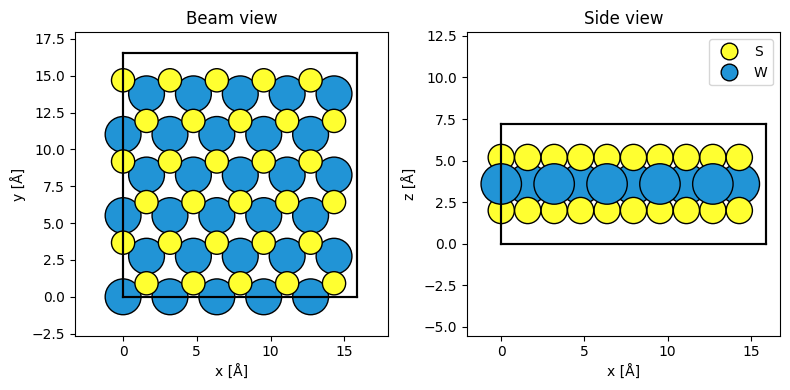

In [2]:
import ase
import abtem
import matplotlib.pyplot as plt

atoms = ase.build.mx2("WS2", vacuum=2)

atoms = abtem.orthogonalize_cell(atoms) * (5, 3, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view")
abtem.show_atoms(atoms, plane="xz", ax=ax2, title="Side view", legend=True)
fig.tight_layout()

In [9]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import ase
from abtem.reconstruct import RegularizedPtychographicOperator
from matplotlib import pyplot as plt

import abtem

[                                        ] | 0% Completed | 343.23 us

[########################################] | 100% Completed | 107.55 ms
[########################################] | 100% Completed | 102.36 ms


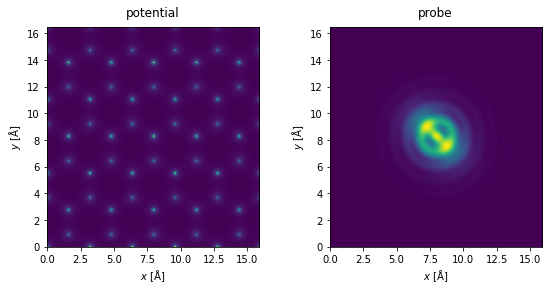

In [21]:
potential = abtem.Potential(
    atoms,
    sampling=0.05,
)

aberrations = {"C10": -130, "C12": 20, "phi12": 0.785, "C30": -2e4}

#aberrations = {"C10": 0, "C12": 0, "phi12": 0, "C30": 0}


probe = abtem.Probe(semiangle_cutoff=20, energy=100e3, **aberrations)

probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
potential.show(ax=ax1, title="potential")
probe.show(ax=ax2, title="probe")
fig.tight_layout()

In [22]:
scan = abtem.GridScan(
    start=(0, 0), end=(1 / 5, 1 / 3), fractional=True, potential=potential,
)

pixelated_detector = abtem.PixelatedDetector()

diffraction_patterns = probe.scan(potential, scan=scan, detectors=pixelated_detector)

diffraction_patterns.compute()

[########################################] | 100% Completed | 5.78 sms


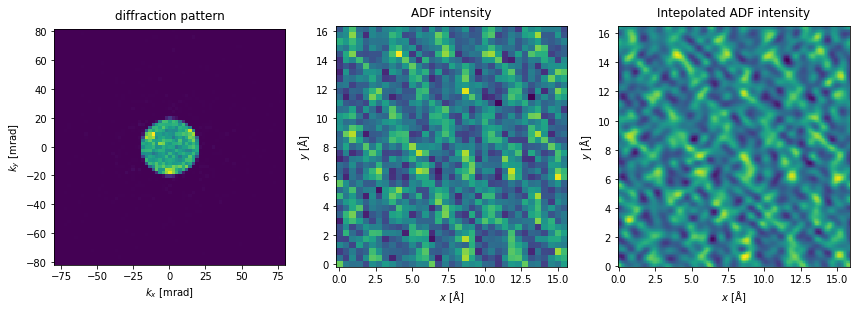

In [23]:
tiled_measurements = diffraction_patterns.tile_scan((5, 3)).poisson_noise(1e5)
cropped_measurements = tiled_measurements.crop(max_angle=80)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))
cropped_measurements.show(ax=ax1, title="diffraction pattern", units="mrad")
tiled_measurements.integrate_radial(50, 150).show(
    ax=ax2, title="ADF intensity"
)
tiled_measurements.integrate_radial(50, 150).interpolate(.1).show(
    ax=ax3, title="Intepolated ADF intensity"
)

plt.tight_layout()

In [24]:
ptycho_operator = RegularizedPtychographicOperator(
    cropped_measurements,
    parameters={"object_px_padding": (0, 0)},
)

ptycho_operator.preprocess()

In [25]:
rpie_objects, rpie_probes, rpie_positions, rpie_sse = ptycho_operator.reconstruct(
    max_iterations=5, return_iterations=True, random_seed=1, verbose=True
)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 6825 steps
--Probe correction is enabled
----Iteration 0, SSE = 7.669e-04
----Iteration 1, SSE = 6.395e-06
----Iteration 2, SSE = 6.129e-06
----Iteration 3, SSE = 5.671e-06
----Iteration 4, SSE = 5.633e-06


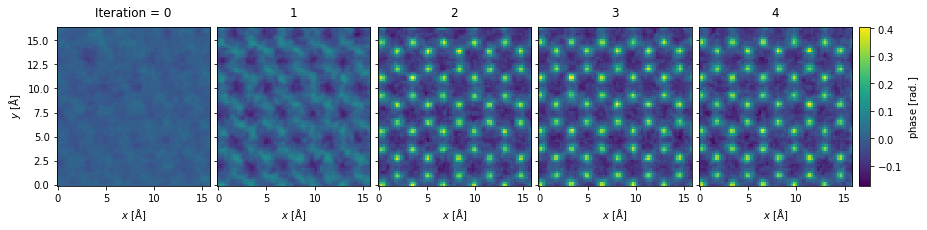

In [26]:
rpie_objects.phase().show(
    explode=True, figsize=(14, 5), cbar=True, common_color_scale=True
);

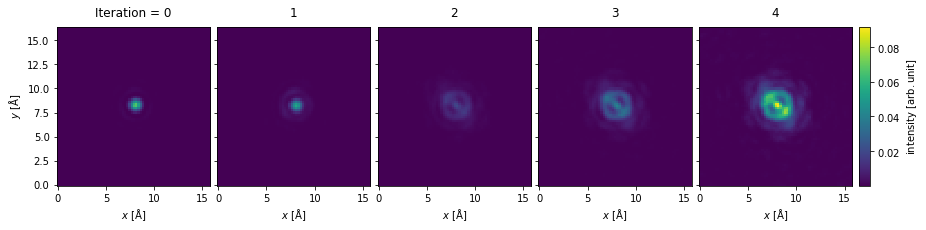

In [27]:
rpie_probes.intensity().show(
    explode=True, figsize=(14, 5), cbar=True, common_color_scale=True, #vmax=1.8e-6
);